In [1]:
from typing import *
import numpy as np
from matplotlib import pyplot as plt
from time import time
from tqdm import tqdm
from numba import jit
import math
from utils.Scene import Scene



%matplotlib inline
plt.rcParams['figure.dpi'] = 140

In [3]:
# Load TX Signal

sig_tx_raw = np.fromfile('data/ch_000/tx_signal_ch_000_00000.float32', dtype='>f4')

len_sig_raw, = sig_tx_raw.shape
len_sig_raw

131072

In [5]:
# Load RX Signals

NUM_SIGNALS = 312

# (It is assumed that the rx signals have the same length as the tx signals)
sig_rx_raw = np.empty([len_sig_raw, NUM_SIGNALS])

for i in range(NUM_SIGNALS):
    sig_rx_raw[:, i] = np.fromfile(f'data/ch_000/rx_signal_ch_000_{i+1:05}.float32', dtype='>f4')

sig_rx_raw.shape

(131072, 312)

In [6]:
# Experiment Specs:

# Sampling freq.
f_samp = 100e6 # [Hz]

f_min, f_max = 2e6, 10e6 # [Hz]    <-- TODO

# Sampling period
dt_samp = 1/f_samp # [s]

# Mean speed of sound (water)
c_sound = 1_484_000.0 # [mm/s]

f_s = f_samp

x_l = len_sig_raw

f0 = int(f_min/f_samp*len_sig_raw) #min of bandpass signal
f1 = int(f_max/f_samp*len_sig_raw) #max freq of bandpass signal

print({'f0': f0, 'f1': f1})

{'f0': 2621, 'f1': 13107}


In [7]:
sig_rx_raw_f = np.fft.fft(sig_rx_raw, axis=0)
sig_tx_raw_f = np.fft.fft(sig_tx_raw)

Text(0.5, 1.0, 'Zoomed Mean Fourier Transform')

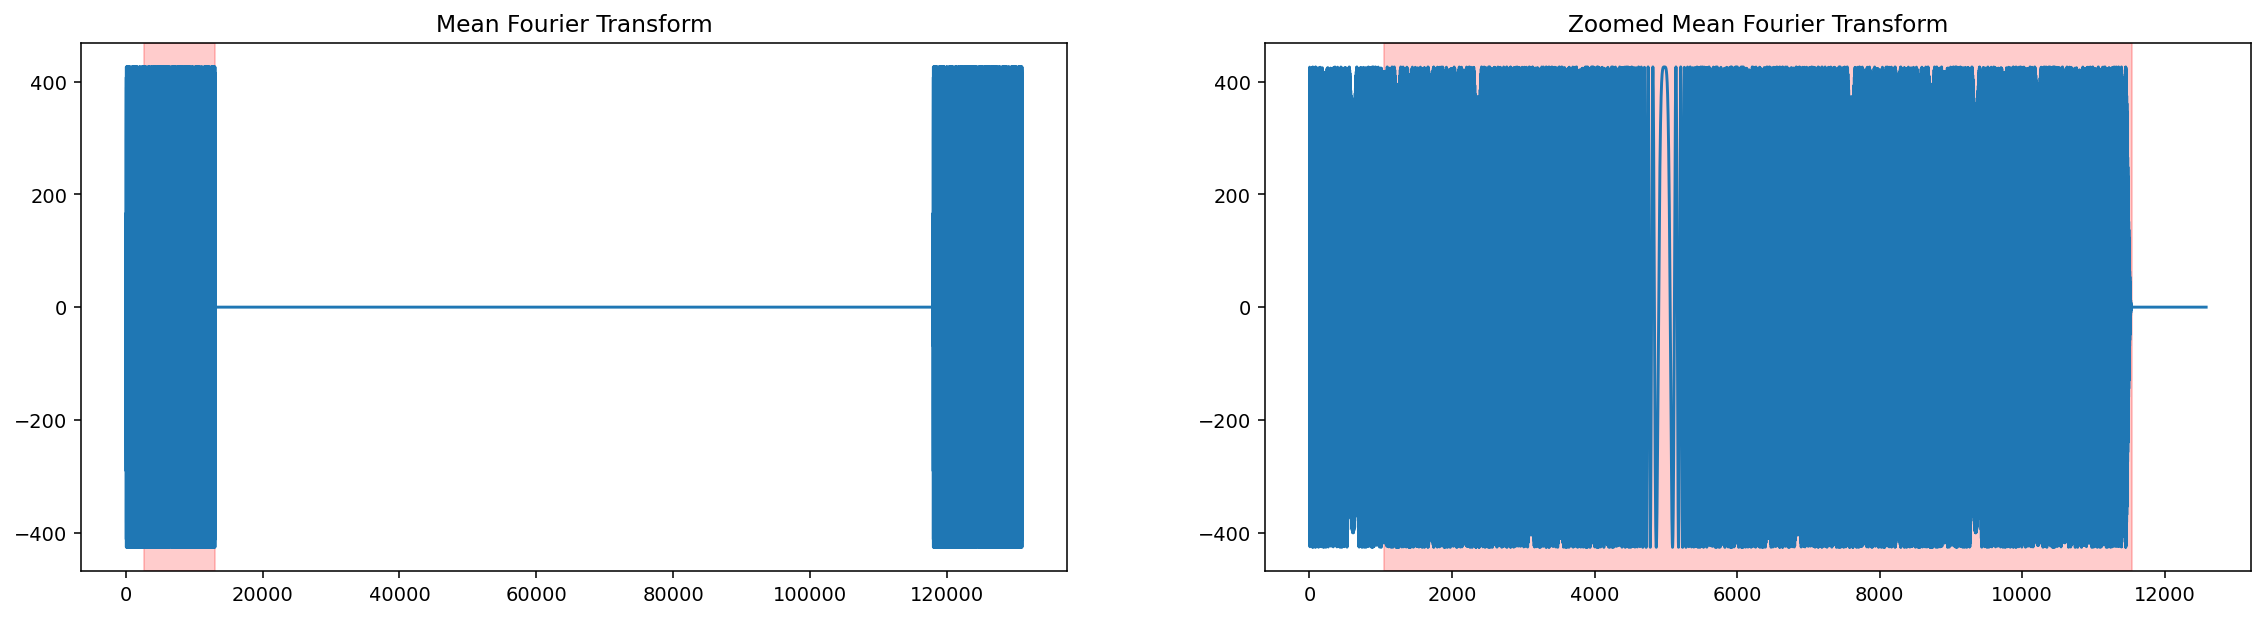

In [8]:
fig, axs = plt.subplots(1, 2, figsize=[20,5])

md = sig_tx_raw_f.real
axs[0].plot(md)
axs[0].axvspan(f0, f1, color='red', alpha=0.2)
axs[0].set_title(f'Mean Fourier Transform')

h = int(0.1*(f1 - f0))
axs[1].plot(md[f0-h:f1+h].real)
axs[1].axvspan(h, (f1 - f0)+h, color='red', alpha=0.2)
axs[1].set_title(f'Zoomed Mean Fourier Transform')


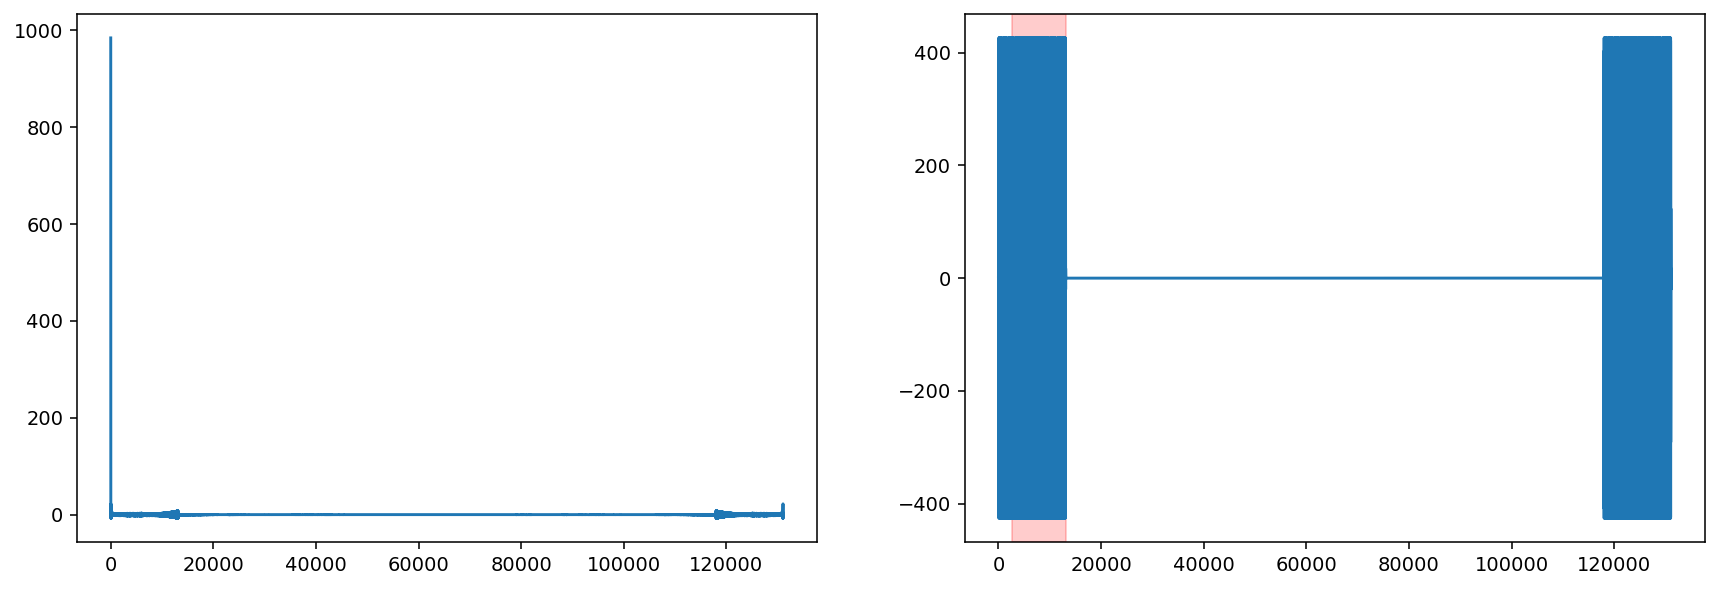

In [9]:


fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
ax1.plot(np.mean(sig_rx_raw_f, axis=1)[:].real)
ax2.plot(sig_tx_raw_f.real)
ax2.axvspan(f0, f1, color='red', alpha=0.2)

plt.show()

In [10]:
sig_rx_np_f = sig_rx_raw_f[f0:f1, :] # bandpass signal only (tx)
sig_tx_bp_f = sig_tx_raw_f[f0:f1] # bandpass signal only (rx)

In [11]:
sig_rx_ir_f = sig_rx_np_f * sig_tx_bp_f[:, None].conj()  # "rotate back phases" of chirp

In [12]:
sig_rx_cir = np.abs(np.fft.ifft(sig_rx_ir_f, axis=0)) # reconstruct whole signal
sig_rx_cir.shape

(10486, 312)

In [13]:
f_res = f_samp/len_sig_raw * (sig_rx_cir.shape[0])
dt = 1/f_res

dt

1.249971390425329e-07

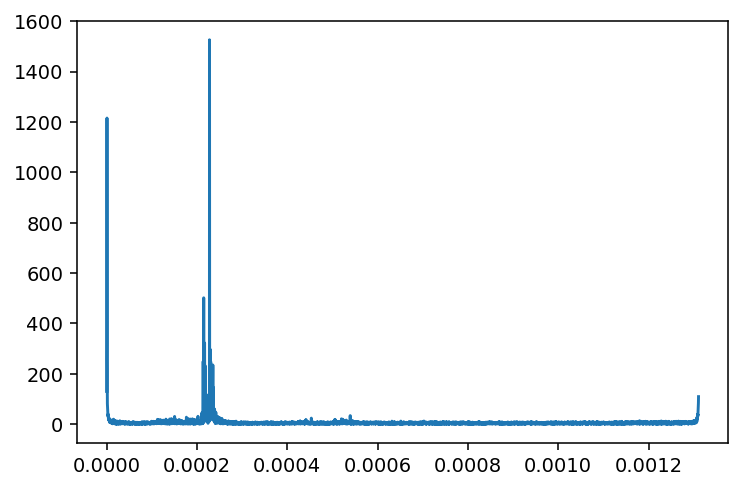

In [14]:
plt.plot(np.linspace(0, sig_rx_cir.shape[0]*dt, sig_rx_cir.shape[0]), sig_rx_cir[:, -2])

In [15]:
# Construct mask for selected relations
def construct_selected(offsets: List[int]) -> np.ndarray:
    selected = np.empty([sum(offsets)], dtype=bool)
    curr_offset = 0
    mode = True
    for n in offsets:
        next_offset = curr_offset+n
        selected[curr_offset:next_offset] = mode
        curr_offset = next_offset
        mode = not mode
    return selected

selected = construct_selected([50, 0, 50, 4, 50, 3, 50, 4, 100, 1])
selected.shape

(312,)

In [16]:
pos_raw = np.genfromtxt('data/positions.csv', delimiter=',', dtype=np.float64)
pos_raw.shape

(312, 8)

In [17]:
# np.savetxt('data/20211209_15_03_40_image_refl_1IKTS1pcbvch1_pa30db_1IPMS_nolna_chirp10mhz_suture/positions.csv', pos, delimiter=",")

In [18]:
sig_rx_sel_cir = sig_rx_cir[:,selected]
pos_raw_sel = pos_raw[selected]

sig_rx_sel_cir.shape

(10486, 300)

In [19]:
pitch = 260e-3 # [mm]
size_piezo =  pos_raw_sel[50, 1] - pos_raw_sel[49, 1] - 2*pitch # [mm]

In [20]:
diff = (pos_raw_sel[49,:2]+pos_raw_sel[50, :2])/2 - pos_raw_sel[100, 4:6]
pos = pos_raw_sel.copy()
pos[:, 4:6] += diff[None,:] 

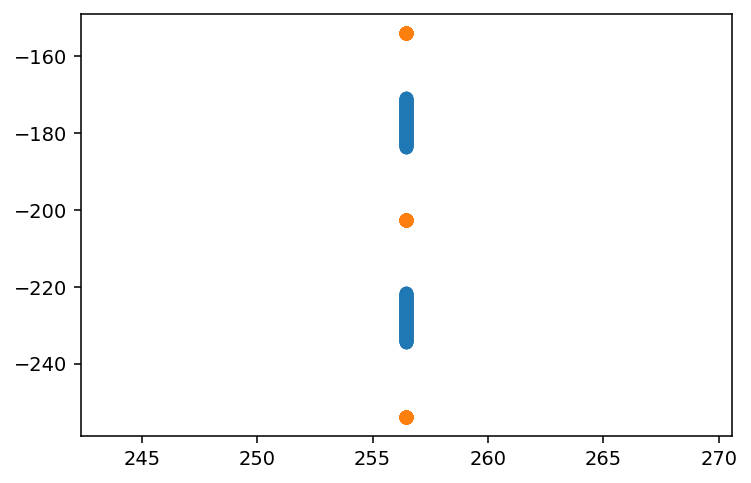

In [21]:
def plot_positions():
    x, y = pos[:,:2].T
    plt.scatter(x, y) 

    x, y = pos[:,4:6].T
    plt.scatter(x, y) 

plot_positions()

## Image reconstruction

In [22]:
c_pos = pos[:, :3].T
p_pos = pos[:, 4:7].T

data = sig_rx_cir.T

In [23]:
# Define image plane
u, v, o = np.array([[0., 100., 0.], [0., 0., -80.], [256, -254, 0.]])

# Define image plane resolution
res_u, res_v = 100, 80

In [24]:
s = Scene(u, v, o, res_u, res_v, p_pos, c_pos, np.full([300], True, dtype=bool))
s.plot_scene()
s.save_figure('plots/exp2_setup.html')

In [25]:
u_scale = np.linspace(0, 1, res_u)[: , None, None]
v_scale = np.linspace(0, 1, res_v)[None, :, None]

grid = (u[None, None, :]*u_scale) + (v[None, None, :]*v_scale) + o[None, None, :]

In [26]:
piezo_filter   = lambda pos: True # np.allclose(pos, np.array([385.0, -110.0, 198.0]))
cMut_filter    = lambda pos: True # any(
#     np.allclose(pos, np.array([k+311.1, -110.0, 198.0]))
#     for k in range(0,61)
#     for l in range(-5, 7, 5)
# )

selected_p = np.apply_along_axis(piezo_filter, 0, p_pos)
selected_c = np.apply_along_axis(cMut_filter, 0, c_pos)
selected = np.logical_and(selected_p, selected_c)
NUM_RELATION = np.sum(selected)

selected_idxs, = selected.nonzero()


NUM_RELATION

300

In [27]:
dr = dt * c_sound

def image_rx_tx(rx_pos, tx_pos, start, stop, rel):
    D_rx = np.linalg.norm(grid - rx_pos, axis= 2)
    D_tx = np.linalg.norm(grid - tx_pos, axis= 2)
    
    D_total = D_rx+D_tx


    Mt = np.zeros([res_u*res_v, stop-start])

    for i in range(start, stop):
        ff = np.ravel( ((D_total) < (i+1)*dr) * ((D_total) > i*dr))
        rsq = np.ravel(D_total**2)

        # Mt computes the approx. inverse
        Mt[:, i-start] = rsq*ff


    p = np.dot(Mt, data[rel,start:stop])
    r = p.reshape([res_u, res_v])
    return r

dr

0.18549575433911883

In [28]:
import math

# Only use samples where ellipsoide goes through the image plane 
# therefore compute minimal and maximal time define interval of interest on samples
distances = np.linalg.norm(p_pos[None,None,:,selected]-grid[:,:,:,None], axis=2) + \
            np.linalg.norm(c_pos[None,None,:,selected]-grid[:,:,:,None], axis=2)

min_dist = np.min(distances)
max_dist = np.max(distances)

lower_sample_idx = math.floor(((min_dist / c_sound)) * f_res) # inclusive
upper_sample_idx = math.ceil(((max_dist / c_sound)) * f_res)+1 # not inclusive

NUM_SAMPLES = upper_sample_idx - lower_sample_idx

NUM_SAMPLES

1099

Text(0.5, 1.0, 'Mean data')

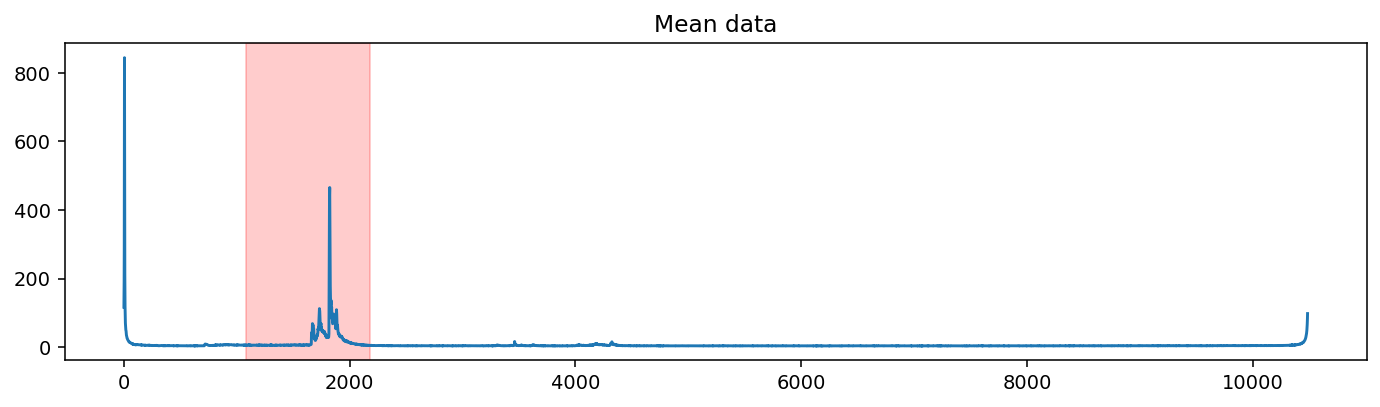

In [29]:
fig, ax1 = plt.subplots(1,1, figsize=(12,3))

ax1.plot(np.mean(data, axis=0))
ax1.axvspan(lower_sample_idx, upper_sample_idx, color='red', alpha=0.2)
ax1.set_title('Mean data')

In [30]:
ri = np.zeros([res_u, res_v])
for i in tqdm(selected_idxs):
        rii = image_rx_tx(c_pos[None,None,:,i], p_pos[None,None,:,i], lower_sample_idx, upper_sample_idx, i)
        ri += rii

100%|██████████| 300/300 [00:36<00:00,  8.30it/s]


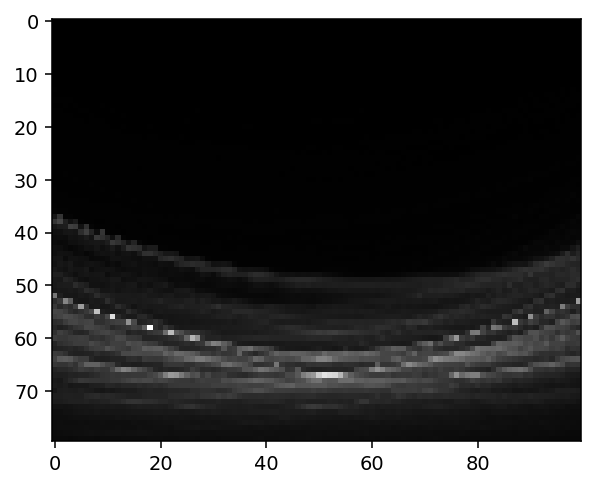

In [31]:
plt.imshow(ri.T, cmap='gray')

In [32]:
# Filter chain by christoph

from scipy.signal import correlate, hilbert

sig_rx_filt = np.fft.ifft(np.fft.fft(sig_rx_raw[:,0])*np.hanning(len_sig_raw)**2)
sig_tx_filt = np.fft.ifft(np.fft.fft(sig_tx_raw[:])*np.hanning(len_sig_raw)**2)
y = correlate(sig_tx_filt, sig_rx_filt,mode='full')

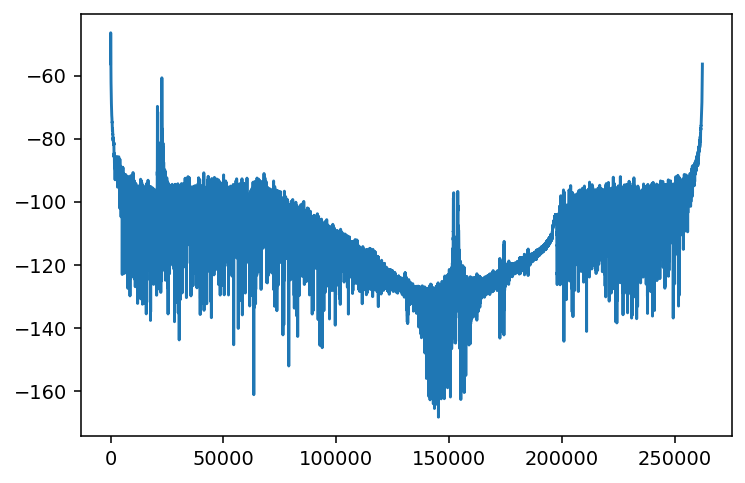

In [33]:
plt.plot(20*np.log10(np.flip(np.abs(hilbert(np.real(np.fft.fftshift(y))))[:])))